In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import seaborn as sns
!pip install linearmodels
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM

## **Table 22. Data ingestion & processing**

In [2]:
# Inflation (CPIAUCSL)
#	Federal Funds Rate (FEDFUNDS)
#	Unemployment Rate (UNRATE)

cpi = pdr.get_data_fred('CPIAUCSL', start='2000-01-01')
fedfunds = pdr.get_data_fred('FEDFUNDS', start='2000-01-01')
unrate = pdr.get_data_fred('UNRATE', start='2000-01-01')

cpi = cpi.reset_index()
fedfunds = fedfunds.reset_index()
unrate = unrate.reset_index()

df = pd.merge(cpi, fedfunds, on='DATE', how='outer')
df = pd.merge(df, unrate, on='DATE', how='outer')
df = df.rename(columns={'CPIAUCSL': 'CPI', 'FEDFUNDS': 'FedFunds', 'UNRATE': 'Unemployment'})

# YoY Inflation
df['Inflation'] = (df['CPI'].pct_change(12, fill_method=None))

df.dropna(inplace=True)
df.set_index('DATE', inplace=True)
print(df.head())

              CPI  FedFunds  Unemployment  Inflation
DATE                                                
2001-01-01  175.6      5.98           4.2   0.037212
2001-02-01  176.0      5.49           4.2   0.035294
2001-03-01  176.1      5.31           4.3   0.029825
2001-04-01  176.4      4.80           4.4   0.032183
2001-05-01  177.3      4.21           4.3   0.035631


## **Table 23. Yearly Box Plots of Inflation Rates (2000-2024)**

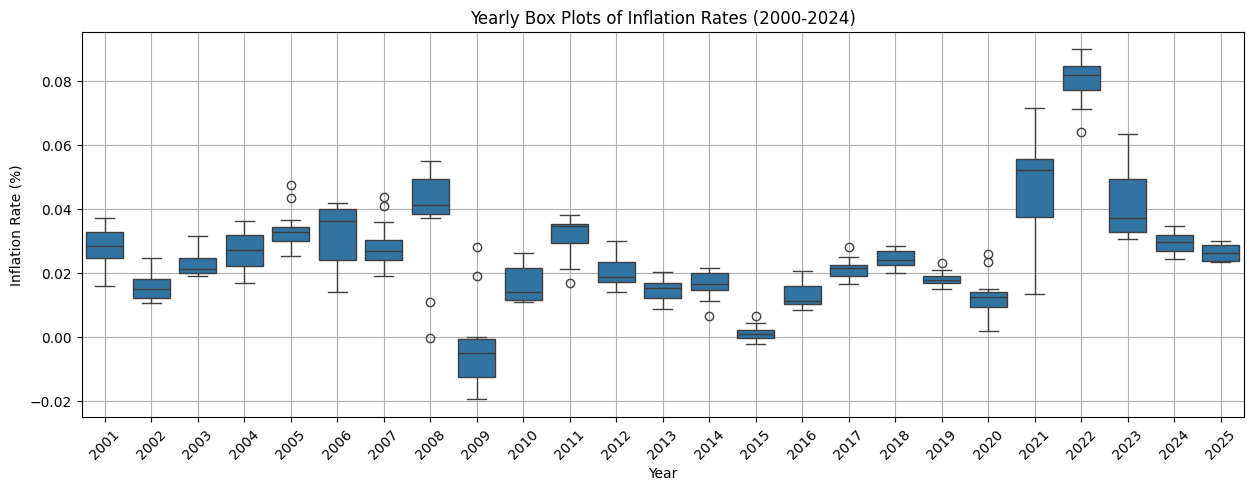

In [3]:
df['Year'] = df.index.year
plt.figure(figsize=(15, 5))
sns.boxplot(x='Year', y='Inflation', data=df)
plt.title('Yearly Box Plots of Inflation Rates (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

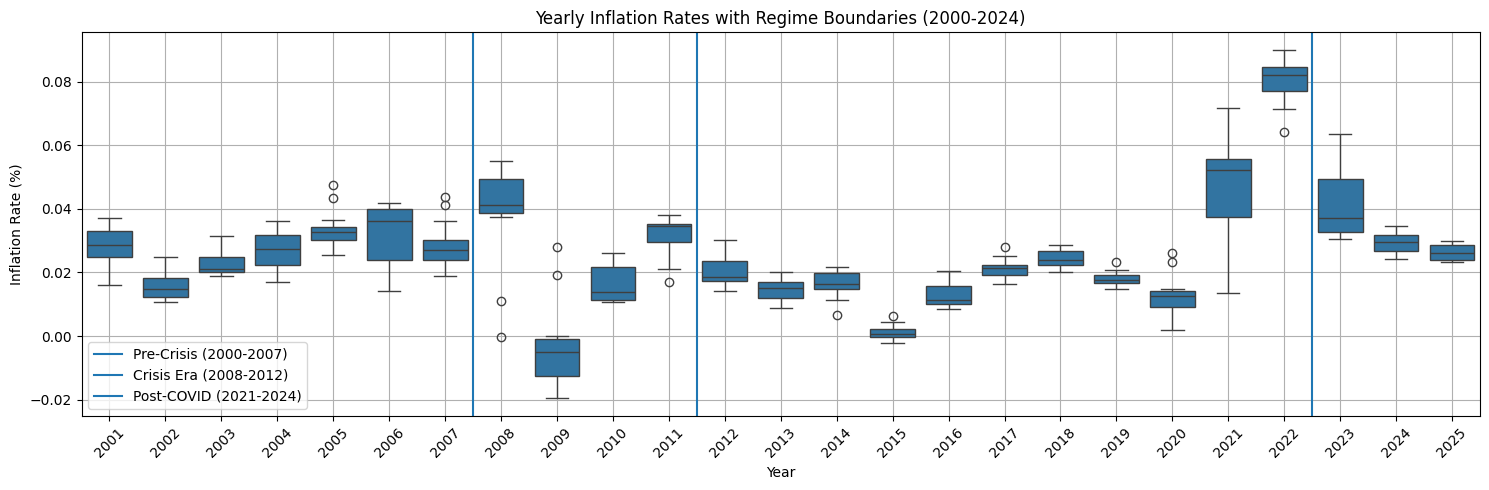

In [4]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='Year', y='Inflation', data=df)
plt.axvline(x=6.5, label='Pre-Crisis (2000-2007)')
plt.axvline(x=10.5, label='Crisis Era (2008-2012)')
plt.axvline(x=21.5, label='Post-COVID (2021-2024)')
plt.title('Yearly Inflation Rates with Regime Boundaries (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## **Table 24. Joint Distribution of Unemployment and Inflation**

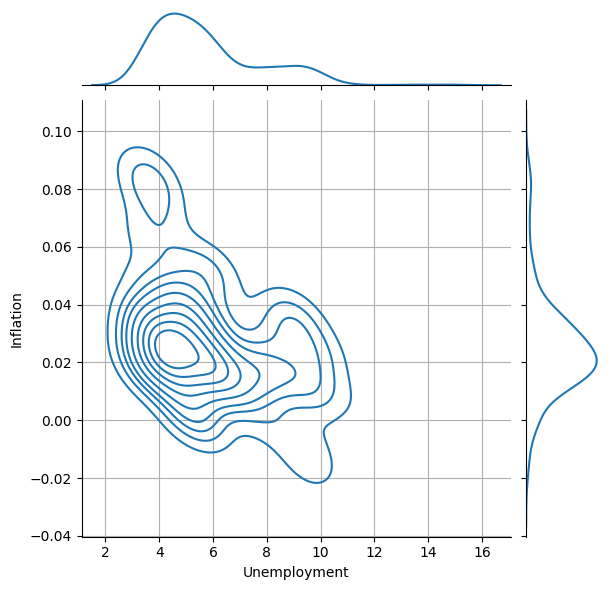

In [5]:
sns.jointplot(x='Unemployment', y='Inflation', data=df, kind='kde')
plt.grid()
plt.show()

## **Table 25. ADF test**

In [6]:
# ADF Test for Inflation
result_inflation = adfuller(df['Inflation'])
print('ADF Statistic (Inflation):', result_inflation[0])
print('p-value (Inflation):', result_inflation[1])

# ADF Test for FedFunds
result_fedfunds = adfuller(df['FedFunds'])
print('ADF Statistic (FedFunds):', result_fedfunds[0])
print('p-value (FedFunds):', result_fedfunds[1])

# ADF Test for Unemployment Rate
result_unemp = adfuller(df['Unemployment'])
print('ADF Statistic (Unemployment):', result_unemp[0])
print('p-value (Unemployment):', result_unemp[1])

ADF Statistic (Inflation): -2.961742972355997
p-value (Inflation): 0.03862489136426692
ADF Statistic (FedFunds): -2.8935144354118414
p-value (FedFunds): 0.046107395088878386
ADF Statistic (Unemployment): -2.923358708668548
p-value (Unemployment): 0.042698346655544735


## **Table 26. OLS regression**

In [7]:
X = sm.add_constant(df[['FedFunds', 'Unemployment']])
model_ols = sm.OLS(df['Inflation'], X).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     33.78
Date:                Tue, 27 May 2025   Prob (F-statistic):           6.54e-14
Time:                        11:15:49   Log-Likelihood:                 793.21
No. Observations:                 292   AIC:                            -1580.
Df Residuals:                     289   BIC:                            -1569.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0426      0.004     10.012   

## **Table 27. Analytical test for endogeneity**

In [18]:
iv_model = IV2SLS.from_formula(
    'Inflation ~ 1 + [FedFunds ~ Unemployment]',
    data=df).fit()

# Wu-Hausman Test
print("\nWu-Hausman Test:")
print(iv_model.wu_hausman())

# Sargan Test
print("\nSargan Test:")
print(iv_model.sargan)


Wu-Hausman Test:
Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 30.9649
P-value: 0.0000
Distributed: F(1,289)

Sargan Test:
Invalid test statistic
Test requires more instruments than endogenous variables.
Sargan's test of overidentification


## **Table 28. Manual Stage1 IV2SLS implementation: Unemployment rate and Fed Funds**

In [8]:
X_stage1 = sm.add_constant(df['Unemployment'])
model_stage1 = sm.OLS(df['FedFunds'], X_stage1).fit()
print(model_stage1.summary())

                            OLS Regression Results                            
Dep. Variable:               FedFunds   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     152.0
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.32e-28
Time:                        11:15:49   Log-Likelihood:                -534.68
No. Observations:                 292   AIC:                             1073.
Df Residuals:                     290   BIC:                             1081.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.9780      0.275     18.133   

## **Table 29. Stage 2 implementation**

In [9]:
df['FedFunds_hat'] = model_stage1.predict(X_stage1)
X_stage2 = sm.add_constant(df['FedFunds_hat'])
model_2sls = sm.OLS(df['Inflation'], X_stage2).fit()
print(model_2sls.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     64.51
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.43e-14
Time:                        11:15:49   Log-Likelihood:                 791.86
No. Observations:                 292   AIC:                            -1580.
Df Residuals:                     290   BIC:                            -1572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0132      0.002      7.316   

## **Table30. Correct 2SLS**

In [10]:
# Dependent variable: Inflation
# Endogenous regressor: FedFunds
# Instrument: Unemployment

iv_model = IV2SLS.from_formula(
    'Inflation ~ 1 + [FedFunds ~ Unemployment]',
    data=df).fit()

print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              Inflation   R-squared:                     -0.0631
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0667
No. Observations:                 292   F-statistic:                    47.198
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        11:15:49   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0132     0.0016     8.1445     0.0000      0.0100      0.0163
FedFunds       0.0069     0.0010     6.8701     0.00

## **Table 31. Residuals vs fitted values**

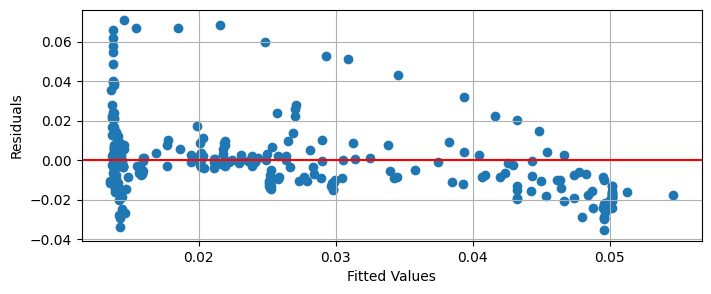

In [11]:
residuals = iv_model.resids
fitted_values = iv_model.fitted_values

plt.figure(figsize=(8,3))
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
# plt.title('Residuals vs Fitted Values (IV2SLS)')
plt.grid()
plt.show()

## **Table 32. Quadratic IV-GMM estimation**

                          IV-2SLS Estimation Summary                          
Dep. Variable:              Inflation   R-squared:                     -0.0682
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0719
No. Observations:                 292   F-statistic:                    47.522
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        11:15:50   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0131     0.0017     7.7359     0.0000      0.0098      0.0164
FedFunds       0.0070     0.0010     6.8936     0.00

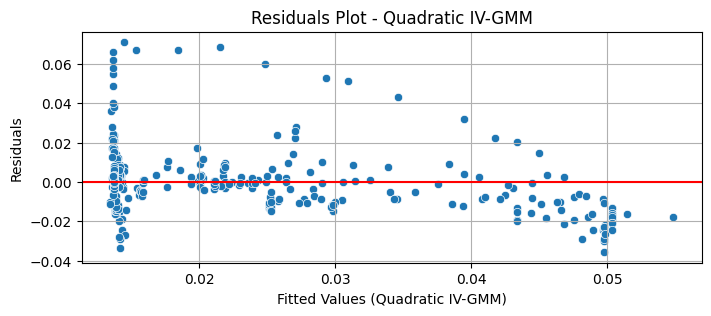

In [12]:
df['Unemp_sq'] = df['Unemployment'] ** 2

iv_model_gmm = IV2SLS.from_formula('Inflation ~ 1 + [FedFunds ~ Unemp_sq]',data=df).fit()
print(iv_model_gmm.summary)

plt.figure(figsize=(8,3))
sns.scatterplot(x=iv_model_gmm.fitted_values.values.ravel(),
                y=iv_model_gmm.resids.values.ravel())
plt.axhline(0, color='red')
plt.xlabel('Fitted Values (Quadratic IV-GMM)')
plt.ylabel('Residuals')
plt.title('Residuals Plot - Quadratic IV-GMM')
plt.grid()
plt.show()

## **Table 33. Log-Log IV GMM**

                          IV-GMM Estimation Summary                           
Dep. Variable:          log_Inflation   R-squared:                      0.1097
Estimator:                     IV-GMM   Adj. R-squared:                 0.1064
No. Observations:                 278   F-statistic:                    22.333
Date:                Tue, May 27 2025   P-value (F-stat)                0.0000
Time:                        12:14:35   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -3.7673     0.0462    -81.619     0.0000     -3.8578     -3.6769
log_FedFunds     0.2389     0.0506     4.725

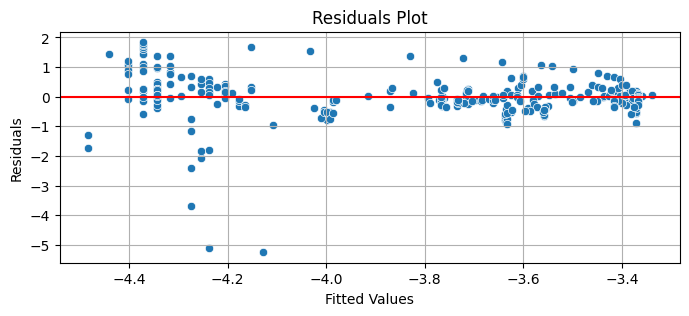

In [22]:
df_log = df.copy()

df_log = df_log[(df_log['Inflation'] > 0) & (df_log['FedFunds'] > 0)]
df_log['log_Inflation'] = np.log(df_log['Inflation'])
df_log['log_FedFunds'] = np.log(df_log['FedFunds'])
df_log = df_log.dropna()

model = IVGMM.from_formula(
    'log_Inflation ~ 1 + [log_FedFunds ~ Unemployment]',
    data=df_log).fit()

print(model.summary)

plt.figure(figsize=(8,3))
sns.scatterplot(x = model.fitted_values.values.ravel(),
                y = model.resids.values.ravel())
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid()
plt.show()